# Softmax regression

In this exercise you will train a softmax regression model to recognize handwritten digits.
  
The general setup is as follows:
* we are given a set of pairs $(x, y)$, where $x \in R^D$ is a vector of real numbers representing the features, and $y \in \{1,...,c\}$ is the target (in our case we have ten classes, so $c=10$),
* for a given $x$ we model the probability of $y=j$ by $$h(x)_j=p_j = \frac{e^{w_j^Tx}}{\sum_{i=1}^c e^{w_i^Tx}},$$
* to find the right $w$ we will optimize the so called multiclass log loss:
$$L(y,p) = \log{p_y},$$
$$J(w) = -\frac{1}{n}\sum_{i=1}^n L(y_i,h(x)),$$
* with the loss function in hand we can improve our guesses iteratively:
    * $w_{ij}^{t+1} = w_{ij}^t - \text{step_size} \cdot \frac{\partial J(w)}{\partial w_{ij}}$,
* we can end the process after some predefined number of epochs (or when the changes are no longer meaningful).

Let's start with importing the MNIST dataset. For convenience, let's use Google's script from TensorFlow tutorial.

In [6]:
!wget -O MNIST_data.zip https://www.dropbox.com/sh/z7h50270eckbrd3/AAAmBulcP1UaEYBYyvBKqXSwa?dl=1
!unzip MNIST_data.zip -d MNIST_data/

--2017-03-15 10:02:11--  https://www.dropbox.com/sh/z7h50270eckbrd3/AAAmBulcP1UaEYBYyvBKqXSwa?dl=1
Translacja www.dropbox.com (www.dropbox.com)... nieudane: Ta nazwa lub usługa jest nieznana.
wget: nie udało się rozwiązać adresu hosta `www.dropbox.com'


Archive:  MNIST_data.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of MNIST_data.zip or
        MNIST_data.zip.zip, and cannot find MNIST_data.zip.ZIP, period.


In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# needs tensorflow 1.0
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

train = mnist.train.next_batch(1000)
test = mnist.train.next_batch(1000)

Extracting MNIST_data/train-images-idx3-ubyte.gz


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Let's take a look at the data. Both train and test are tuples with two numpy array. In the first array you'll find the images (encoded as pixel intensities) and in the second one you'll find the labels (one-hot encoded).

In [7]:
print type(train)

print type(train[0])
print type(train[1])

print (train[0][4] > 0.01).reshape(28,28).astype(int)

<type 'tuple'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 

Now let us see the data in a more humane way.

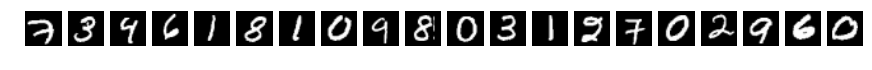

In [14]:
num_samples = 20
samples = range(num_samples)
fig, subplots = plt.subplots(1, num_samples)
fig.set_size_inches(15, 15)

for i, s in enumerate(subplots.flatten()):
    s.imshow(np.reshape(train[0][i, :], [28, 28]), cmap='gray')
    s.axis('off')

Next, we prepare $X$ and $y$ variables

In [2]:
X = train[0]
y = train[1]

X_test = test[0]
y_test = test[1]

To train the model we will (obviously) use gradient descent. Inside the loop we need a method to compute the gradients. Let's start with implementing it, together with some helper functions.

In [3]:
# We will store the weights in a D x c matrix, where D is the number of features, and c is the number of classes
#weights = (...) # TODO: Fill in, be sure to have the right shape!
weights = np.zeros([X.shape[1], 10])


def softmax(z):
    # z is cases x outs
    up = np.exp(z)
    down = np.sum(up, axis=1).reshape(-1, 1)
    return up / down

def almost_equal(a, b):
    return a - b < 1e9

almost_equal(softmax(np.log(np.array([[1, 2], [3, 4]]))),
             np.array([[1./3, 2./3], [3./7, 4./7]]))


def predict(weights, X):
    return softmax(np.matmul(X, weights))

def compute_loss_and_gradients(weights, X, y, l2_reg):
    p = predict(weights, X)
    masked_loss = -np.log(p) * y
    assert sum((masked_loss != 0.).flatten()) == X.shape[0]
    loss_per_example = np.sum(masked_loss, axis=1)
    loss = np.average(loss_per_example) + l2_reg * np.sum(weights ** 2)
    
    # p shape [example x class prob]
    # y shape [example x class exp. prob]
    # X shape [example x features]
    grad = np.matmul((p - y).T,X).T / X.shape[0] + l2_reg * 2 * weights
    
    return loss, grad

We are now in position to complete the training pipeline.

If you have problems with convergence, be sure to check the gradients numerically.

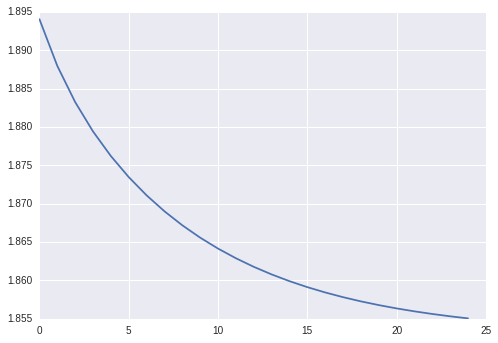

In [15]:
l2_reg = 0.5
n_epochs = 25
lr = 0.05

losses = []
for i in range(n_epochs):
    loss, grad = compute_loss_and_gradients(weights, X, y, l2_reg)
    losses.append(loss)
    
    weights -= lr * grad

plt.plot(losses)

Now compute your accuracy on the training and test sets.

In [4]:
def conf_matrix(pred_class, real_class, class_no):
    print 'Row represents real classes - similar to P(y|yreal=row)'
    for real_cl in range(class_no):
        row = []
        for pred_cl in range(class_no):
            cnt = 0
            for p, r in zip(pred_class, real_class):
                if p == pred_cl and r == real_cl:
                    cnt += 1
            row.append(cnt)
        
        print real_cl,
        row = np.array(row)
        for v in row * 1000 / np.sum(row):
            print '%03d' % int(v),
        print ''
        
def check_on_set(X, y, weights):
    p = predict(weights, X)
    pred_class, real_class = np.argmax(p, axis=1), np.argmax(y, axis=1)
    print 'Accuracy:', np.average(pred_class == real_class)
    conf_matrix(pred_class, real_class, 10)
    
check_on_set(X, y, weights)
check_on_set(X_test, y_test, weights)

Accuracy: 0.113
Row represents real classes - similar to P(y|yreal=row)
0 1000 000 000 000 000 000 000 000 000 000 
1 1000 000 000 000 000 000 000 000 000 000 
2 1000 000 000 000 000 000 000 000 000 000 
3 1000 000 000 000 000 000 000 000 000 000 
4 1000 000 000 000 000 000 000 000 000 000 
5 1000 000 000 000 000 000 000 000 000 000 
6 1000 000 000 000 000 000 000 000 000 000 
7 1000 000 000 000 000 000 000 000 000 000 


8 1000 000 000 000 000 000 000 000 000 000 
9 1000 000 000 000 000 000 000 000 000 000 
Accuracy: 0.099
Row represents real classes - similar to P(y|yreal=row)
0 1000 000 000 000 000 000 000 000 000 000 
1 1000 000 000 000 000 000 000 000 000 000 
2 1000 000 000 000 000 000 000 000 000 000 
3 1000 000 000 000 000 000 000 000 000 000 
4 1000 000 000 000 000 000 000 000 000 000 


5 1000 000 000 000 000 000 000 000 000 000 
6 1000 000 000 000 000 000 000 000 000 000 
7 1000 000 000 000 000 000 000 000 000 000 
8 1000 000 000 000 000 000 000 000 000 000 
9 1000 000 000 000 000 000 000 000 000 000 


We can also visualize the weights learned by our algorithm. Try to anticipate the result before executing the cell below.

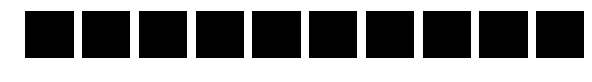

In [6]:
def plot_w(weights):
    fig, subplots = plt.subplots(1, 10)
    fig.set_size_inches(10, 10)

    for i, s in enumerate(subplots.flatten()):
        s.imshow(np.reshape(np.array(weights[:, i]), [28, 28]), cmap='gray')
        s.axis('off')
        
plot_w(weights)

Note that we only used a small portion of the data to develop the model. Now, implement the training on full data. 
Make sure to leverage the `mnist.train.next_batch(...)` method. Also, validate your model properly and find a good value for `l2_reg` hyperparameter. Try to experiment with `batch_size`.

In [6]:
X_val, y_val = mnist.validation.next_batch(2000)

def train_mnist(l2_reg = 0.0, n_epochs = 300, lr = 0.45, batch_sz = 50):
    weights = np.zeros([28**2, 10])
    losses = []
    for i in range(n_epochs):
        batch = mnist.train.next_batch(batch_sz)
        loss, grad = compute_loss_and_gradients(weights, batch[0], batch[1], l2_reg)
        losses.append(loss)
        
        weights -= lr * grad
        
    p = predict(weights, X_val)
    pred_class, real_class = np.argmax(p, axis=1), np.argmax(y_val, axis=1)
    return weights, np.average(pred_class == real_class)
 
par_val, accs = [], []
for par in np.exp(np.linspace(np.log(0.3), np.log(0.7), 20)):
    par_val.append(par)
    weights, acc = train_mnist(lr=par)
    accs.append(acc)
plt.scatter(par_val, accs)

KeyboardInterrupt: 

In [10]:
weights, val_acc = train_mnist()
print 'valacc', val_acc
X_test, y_test = mnist.test.next_batch(10000)
check_on_set(X_test, y_test, weights)

valacc 0.8955


Accuracy: 0.9073
Row represents real classes - similar to P(y|yreal=row)
0 967 000 006 001 000 009 012 001 003 000 


1 000 967 008 003 000 002 003 000 012 000 
2 006 001 903 007 010 003 016 013 029 006 


3 002 000 031 849 000 069 004 011 016 011 
4 002 002 007 001 906 000 016 002 007 056 
5 010 004 011 020 011 885 014 003 028 011 


6 010 003 006 001 007 017 948 001 004 000 
7 003 013 035 003 009 000 000 888 001 043

 
8 006 009 017 021 007 050 015 010 845 016 
9 008 004 004 008 030 013 000 015 008 902 
